In [45]:
%matplotlib inline
import numpy as np
import pylab as plt
import seaborn as snb

from scipy.stats import norm
from scipy.integrate import quad

from importlib import reload

import ep_grad_obs as EP
reload(EP);

snb.set_style('darkgrid')


### Prepare kernel

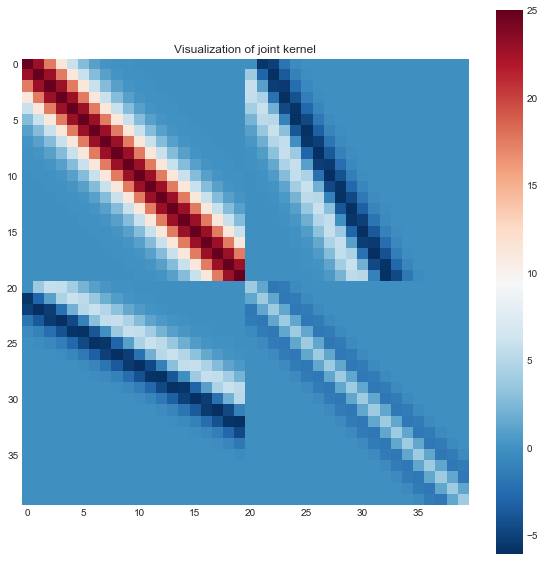

In [37]:
N = 20
M = 20

k1, k2, jitter = 5., 2.5, 1e-8

# sample input domain and prepare kernel
t = np.linspace(-10, 10, N)[:, None]
t2 = np.linspace(-10, 25, M)[:, None]

K = EP.generate_joint_derivative_kernel(t, t2, k1, k2)

# visualize
plt.figure(figsize = (10, 10))
plt.imshow(K, cmap = plt.cm.RdBu_r)
plt.grid(False)
plt.colorbar()
plt.title('Visualization of joint kernel')

### Data

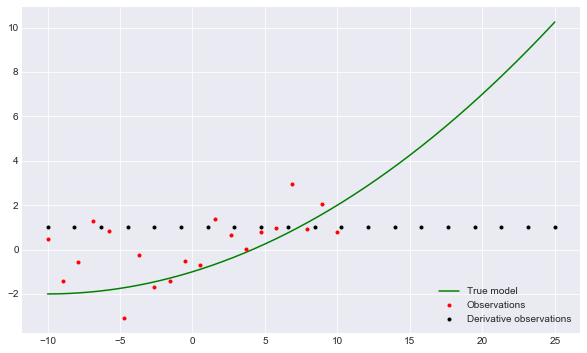

In [38]:
from scipy.stats import t as stud_t

sigma2 = 2.

y0 = lambda x: 1e-2*(x+10)**2 -2.# -stud_t.logpdf(x, 1) - 4.5

np.random.seed(0)
y = y0(t) + np.random.normal(0, np.sqrt(sigma2), size = (N, 1)) 

# observations
z = np.ones((M, 1))

# for prediction
P = 1001
t_pred = np.linspace(-10, 25, P)[:, None]

plt.figure(figsize = (10, 6))
ts = np.linspace(-10, 10, 1001)
plt.plot(t_pred, y0(t_pred), 'g-', label = 'True model')
plt.plot(t, y, 'r.', label = 'Observations');
plt.plot(t2, z, 'k.', label = 'Derivative observations')
plt.legend(loc = 'lower right')
plt.grid(True)


### EP approximation

In [39]:
mu, Sigma_full, logZ = EP.EP_grad_obs(t, t2, y, z, K, sigma2)

Itt 0, -log Z = 60.131451360
Itt 1, -log Z = 60.121155705
Itt 2, -log Z = 60.121156170
Converged in 3 iterations with diff_mu = 5.9521e-07 and diff_Sigma = 1.0976e-07


### Plot posterior

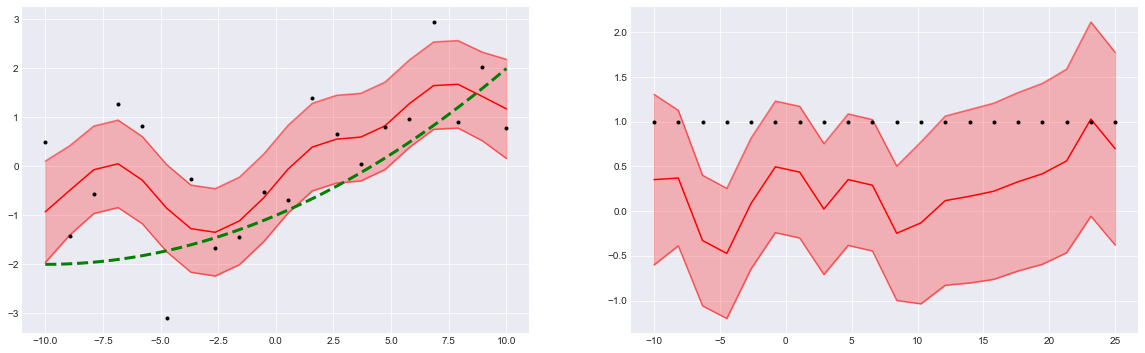

In [40]:
def plot_with_uncertainty(x, y, ystd=None, color = 'r'):
    
    plt.plot(x, y, color=color)
    
    if not ystd is None:
        lower, upper = y - np.sqrt(ystd), y + np.sqrt(ystd)
        plt.plot(x, lower, color=color, alpha=0.5)
        plt.plot(x, upper, color=color, alpha=0.5)
        
        plt.fill_between(x.ravel(), lower, upper, color=color, alpha=0.25)

Sigma = np.diag(Sigma_full)
        
plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plot_with_uncertainty(t, mu[:N], ystd=np.sqrt(Sigma[:N]), color = 'r')
plt.plot(t, y, 'k.')
plt.plot(ts, y0(ts), 'g--', linewidth = 3.)
plt.grid(True)

plt.subplot(1, 2, 2)
plot_with_uncertainty(t2, mu[N:], ystd=np.sqrt(Sigma[N:]), color = 'r')
plt.plot(t2, z, 'k.')
plt.grid(True)

### Predict

MSE: 4.595


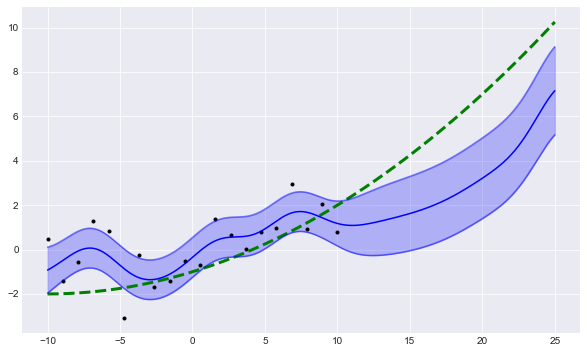

In [48]:
pred_mean, pred_var = EP.predict(mu, Sigma_full, K, t, t2, t_pred, k1, k2)

plt.figure(figsize = (10, 6))
plt.plot(t, y, 'k.')
plt.plot(t_full, y0(t_full), 'g--', linewidth = 3.)
plot_with_uncertainty(t_full, pred_mean, ystd=np.sqrt(pred_var), color = 'b')
plt.grid(True)

mse = np.mean((pred_mean - y0(t_full).ravel())**2)
print('MSE: %4.3f' % mse)

### GPy

In [50]:
import GPy

In [55]:
se = GPy.kern.RBF(input_dim = 1, lengthscale=k2, variance=k1**2)
se_der = GPy.kern.DiffKern(se, 0)

gauss = GPy.likelihoods.Gaussian(variance=sigma2)
probit = GPy.likelihoods.Binomial(gp_link = GPy.likelihoods.link_functions.Probit(nu=1., fixed=True))
model = GPy.core.MultioutputGP(X_list=[t, t2], Y_list=[y, z], kernel_list=[se, se_der], likelihood_list = [gauss, probit])

print('Objective fun: %5.4f' % model.objective_function())

Objective fun: 60.1212


### Pr

In [14]:
X = np.zeros((len(t_full), 2))
X[:, 0] = t_full.ravel()
    
mu_gpy, Sigma_gpy = model.predict(X, include_likelihood=False, full_cov=True)
sigma_gpy = np.diag(Sigma_gpy)

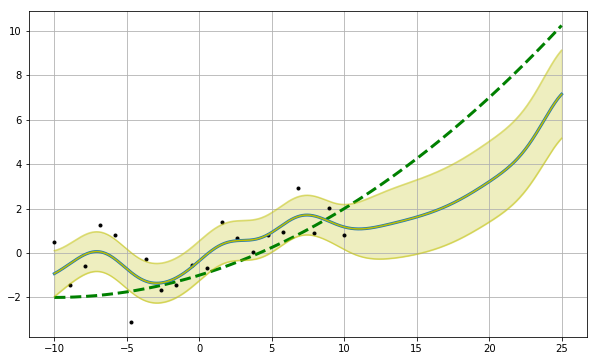

In [15]:
plt.figure(figsize = (10, 6))
plt.plot(t, y, 'k.')
plt.plot(t_full, y0(t_full), 'g--', linewidth = 3.)


plt.plot(t_full, pred_mean, linewidth = 3.)
plot_with_uncertainty(t_full, mu_gpy.ravel(), ystd=np.sqrt(sigma_gpy), color = 'y')
plt.grid(True)
